In [149]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.utils.class_weight import compute_class_weight


In [150]:
# Display setting to better visualize notebook
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',10)
pd.set_option('display.width',1000)

In [151]:
# Read Aggregated  data
df = pd.read_csv('Aggregated_data_provider_level_csv')

In [152]:
df.shape

(5410, 55)

In [153]:
#Feature Engineering: 
#Convert columns to datetime and claim duration in days and create a new column 
df['ClaimStartDt'] = pd.to_datetime(df['ClaimStartDt'])
df['ClaimEndDt'] = pd.to_datetime(df['ClaimEndDt'])
df['claim_duration'] = (df['ClaimEndDt'] - df['ClaimStartDt']).dt.days

In [154]:
# Calculate patient age at the time of service
df['DOB']=pd.to_datetime(df['DOB'])
df['Patient_Age'] = (df['ClaimStartDt'] - df['DOB']).dt.days // 365  # Convert days to years

In [155]:
# List of diagnosis and procedure columns
diagnosis_cols = [col for col in df.columns if 'ClmDiagnosisCode' in col]
procedure_cols = [col for col in df.columns if 'ClmProcedureCode' in col]

# Calculate number of non-null diagnoses and procedures
df['NumDiagnoses'] = df[diagnosis_cols].notna().sum(axis=1)
df['NumProcedures'] = df[procedure_cols].notna().sum(axis=1)


In [156]:
# Time of Year: Extract month  from ClaimStartDt.
df['ClaimMonth'] = df['ClaimStartDt'].dt.month

In [157]:
# Calculate Total Reimbursed Amount
df['TotalReimbursedAmt'] = (
    df['InscClaimAmtReimbursed'] + 
    df['IPAnnualReimbursementAmt'] + 
    df['OPAnnualReimbursementAmt']
)

In [158]:
# Calculate Total Deductible Amount
df['Tot_Deductible_Amt'] = (
    df['DeductibleAmtPaid'] + 
    df['IPAnnualDeductibleAmt'] + 
    df['OPAnnualDeductibleAmt']
)

In [159]:
# Calculate Reimbursement Per Day
df['ReimbursementPerDay'] = df['InscClaimAmtReimbursed'] / df['claim_duration']
# Handle division by zero (inf values)
df['ReimbursementPerDay'] = df['ReimbursementPerDay'].replace([np.inf, -np.inf], np.nan)

In [160]:
# Calculate Stay at Hospital in Days
df['AdmissionDt']= pd.to_datetime(df['AdmissionDt'])
df['DischargeDt']= pd.to_datetime(df['DischargeDt'])
df['StayAtHospitalInDays'] = (df['DischargeDt'] - df['AdmissionDt']).dt.days

In [161]:
df.columns

Index(['Provider', 'PotentialFraud', 'BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'Ch

In [162]:
selected_features = [
    'PotentialFraud','InscClaimAmtReimbursed', 'TotalReimbursedAmt', 'DeductibleAmtPaid', 'NumDiagnoses', 
    'NumProcedures', 'claim_duration', 'ReimbursementPerDay', 'StayAtHospitalInDays', 
    'IPAnnualReimbursementAmt', 'OPAnnualReimbursementAmt', 'Patient_Age', 
    'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 
    'ChronicCond_Cancer', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 
    'ChronicCond_stroke', 'ClaimMonth', 'Tot_Deductible_Amt'
]


In [163]:
# Create a new DataFrame with selected features
df_selected = df[selected_features]
# Display the first few rows
df_selected.head()

,PotentialFraud,InscClaimAmtReimbursed,TotalReimbursedAmt,DeductibleAmtPaid,NumDiagnoses,NumProcedures,claim_duration,ReimbursementPerDay,StayAtHospitalInDays,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,Patient_Age,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_stroke,ClaimMonth,Tot_Deductible_Amt
0,No,4185.60,24406.80,213.60,1,2,0,NaN,3.0,17606.00,2615.20,97,1.40,1.24,1.32,1.80,1.16,1.08,1.76,1,1574.64
1,Yes,4588.41,14834.77,502.17,1,2,8,573.551250,9.0,7568.18,2678.18,96,1.58,1.39,1.52,1.92,1.24,1.15,1.91,12,2170.71
2,No,350.13,6896.91,2.08,1,0,0,NaN,NaN,4351.88,2194.90,99,1.57,1.41,1.66,1.89,1.30,1.28,1.89,1,1059.78
3,Yes,241.12,5974.84,3.18,1,0,13,18.547692,NaN,3623.99,2109.73,100,1.63,1.42,1.56,1.86,1.31,1.23,1.89,12,1018.67
4,No,468.19,5247.91,45.33,1,1,0,NaN,7.0,3050.00,1729.72,98,1.64,1.44,1.69,1.83,1.32,1.29,1.83,1,960.05


In [164]:
df_selected.shape

(5410, 21)

Accuracy: 0.8272
Precision: 0.3346
Recall: 0.8614
F1-score: 0.4820
ROC-AUC: 0.9164
Confusion Matrix:
 [[808 173]
 [ 14  87]]


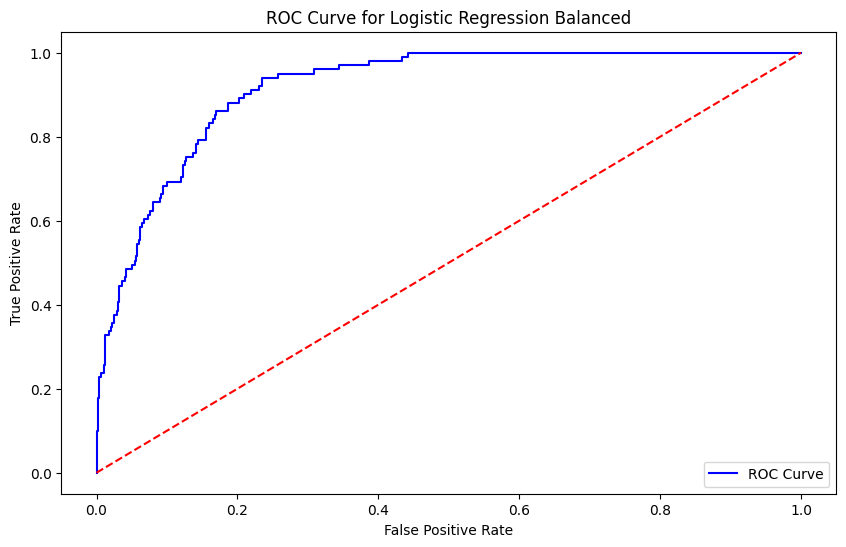

In [165]:
# Models Trainging ,Evaluation  and Features importances 
# 1B. Logistic Regression with balanced class weight

# Define features and target variable
X = df_selected.drop(columns=['PotentialFraud'])  
y = df_selected['PotentialFraud'].map({'Yes': 1, 'No': 0}) 

# Handle missing values
X.fillna(X.median(numeric_only=True), inplace=True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train the model
log_reg_balanced = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg_balanced.fit(X_train, y_train)

# Predictions
y_pred = log_reg_balanced.predict(X_test)
y_prob = log_reg_balanced.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')

# Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Balanced')
plt.legend(loc='lower right')
plt.show()

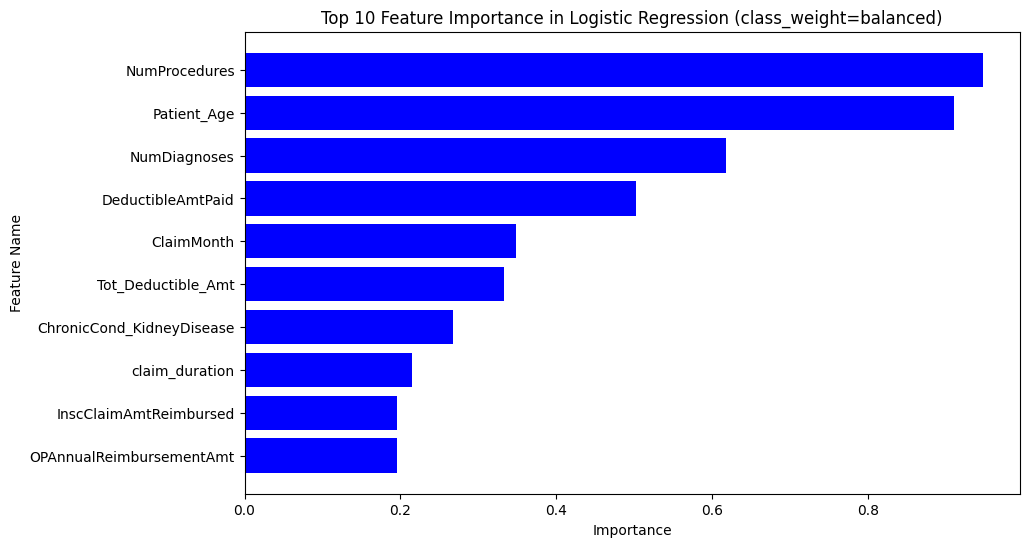

In [166]:
# Get feature importance (absolute values of coefficients)
feature_importance = np.abs(log_reg.coef_[0])  # Taking absolute values for comparison
feature_names = X.columns  # Original feature names

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)  # Sort by importance
# Select top 10 most important features
top_10_features = importance_df.head(10)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='blue')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 Feature Importance in Logistic Regression (class_weight=balanced)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

Accuracy: 0.7569
Precision: 0.2575
Recall: 0.8515
F1-score: 0.3954
ROC-AUC: 0.8601
Confusion Matrix:
 [[733 248]
 [ 15  86]]


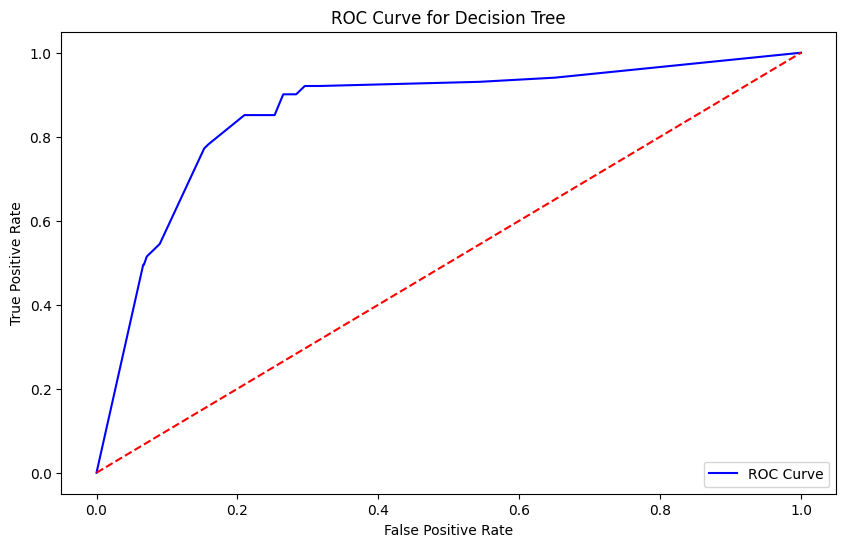

In [167]:
# 2B. Decision tree model with balanced class_weight
# Define features and target variable
X = df_selected.drop(columns=['PotentialFraud'])  
y = df_selected['PotentialFraud'].map({'Yes': 1, 'No': 0}) 

# Handle missing values
X.fillna(X.median(numeric_only=True), inplace=True)

# Standardize the features (Not necessary for Decision Trees, but for consistency)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train the Decision Tree model with class_weight='balanced'
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

# Predictions
y_pred = dt_model.predict(X_test)
y_prob = dt_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')

# Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.legend(loc='lower right')
plt.show()

Top 10 Most Important Features:
                       Feature  Importance
4               NumProcedures    0.646570
18                 ClaimMonth    0.119700
9    OPAnnualReimbursementAmt    0.042152
2           DeductibleAmtPaid    0.036655
10                Patient_Age    0.034244
11      ChronicCond_Alzheimer    0.023707
12   ChronicCond_Heartfailure    0.022463
8    IPAnnualReimbursementAmt    0.019172
1          TotalReimbursedAmt    0.012526
16  ChronicCond_IschemicHeart    0.009283


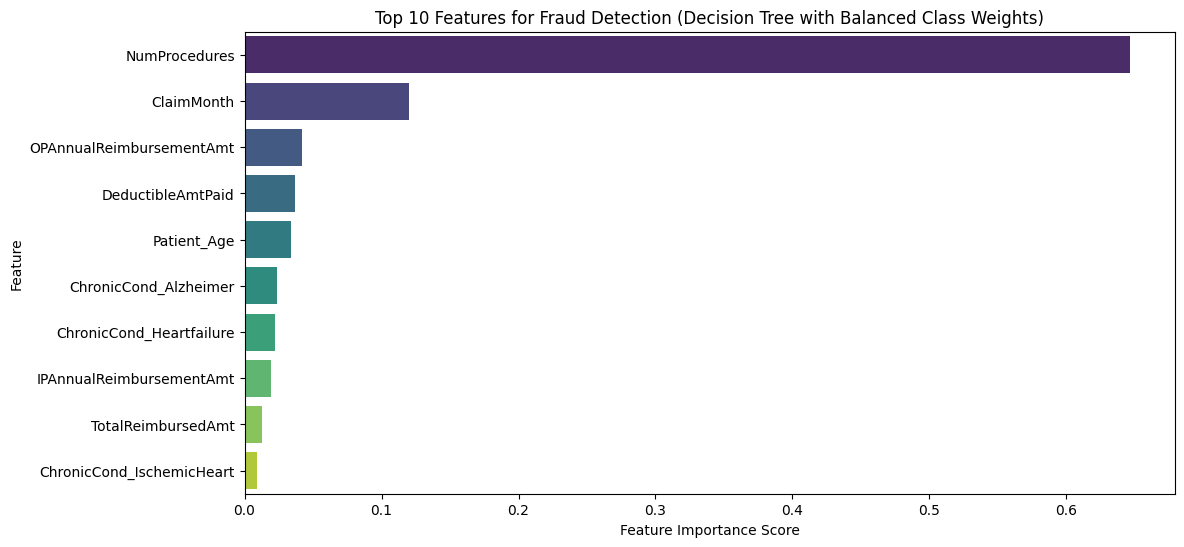

In [168]:
# Define features and target variable
X = df_selected.drop(columns=['PotentialFraud'])  
y = df_selected['PotentialFraud'].map({'Yes': 1, 'No': 0}) 

# Handle missing values
X.fillna(X.median(numeric_only=True), inplace=True)

# Standardize the features (optional for tree-based models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train the Decision Tree model with class_weight='balanced'
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

# Get feature importance
feature_importance = dt_model.feature_importances_
feature_names = X.columns  # Original feature names

# Create a DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)  # Sort by importance

# Select top 10 features
top_10_features = importance_df.head(10)

# Display top 10 feature importance
print("Top 10 Most Important Features:\n", top_10_features)

# Plot the top 10 features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
plt.title('Top 10 Features for Fraud Detection (Decision Tree with Balanced Class Weights)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.show()

Accuracy: 0.9261
Precision: 0.6981
Recall: 0.3663
F1-score: 0.4805
ROC-AUC: 0.9090
Confusion Matrix:
 [[965  16]
 [ 64  37]]


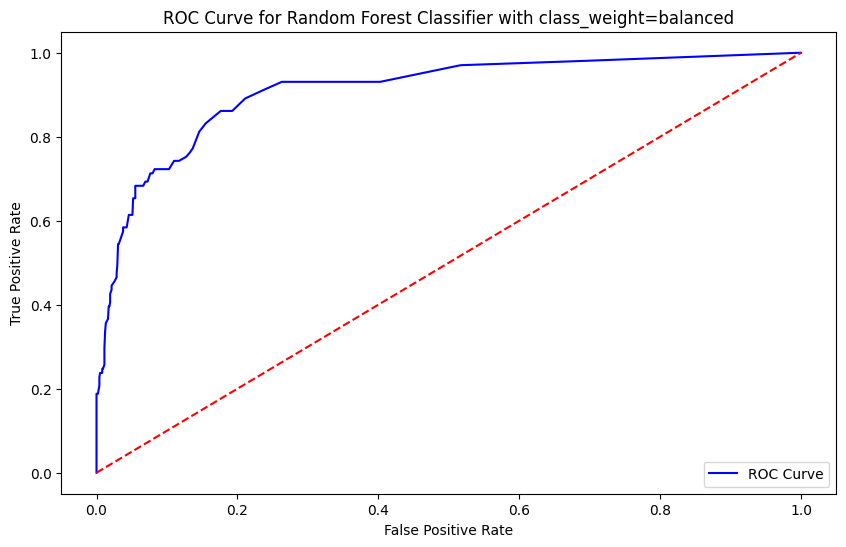

In [169]:
# 3B. Random Forest model with balanced class_weight
# Ensure you're working with an explicit copy
df_selected = df_selected.copy()

# Replace infinite values with NaN
df_selected.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns with only NaN values
df_selected.dropna(axis=1, how='all', inplace=True)

# Define features and target variable
X = df_selected.drop(columns=['PotentialFraud'])  
y = df_selected['PotentialFraud'].map({'Yes': 1, 'No': 0}) 

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train Random Forest model pipeline with class_weight='balanced'
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))  # Apply class weighting
])

model.fit(X_train, y_train)

# Make Predictions and Evaluate the Model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Evaluate model performance with different classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')

# Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier with class_weight=balanced')
plt.legend(loc='lower right')
plt.show()

Top 10 Most Important Features:
                     Feature  Importance
0             NumProcedures    0.188800
1         DeductibleAmtPaid    0.135496
2    InscClaimAmtReimbursed    0.117613
3                ClaimMonth    0.079477
4            claim_duration    0.075171
5        TotalReimbursedAmt    0.058549
6               Patient_Age    0.053765
7       ReimbursementPerDay    0.043606
8        Tot_Deductible_Amt    0.037847
9  IPAnnualReimbursementAmt    0.034467


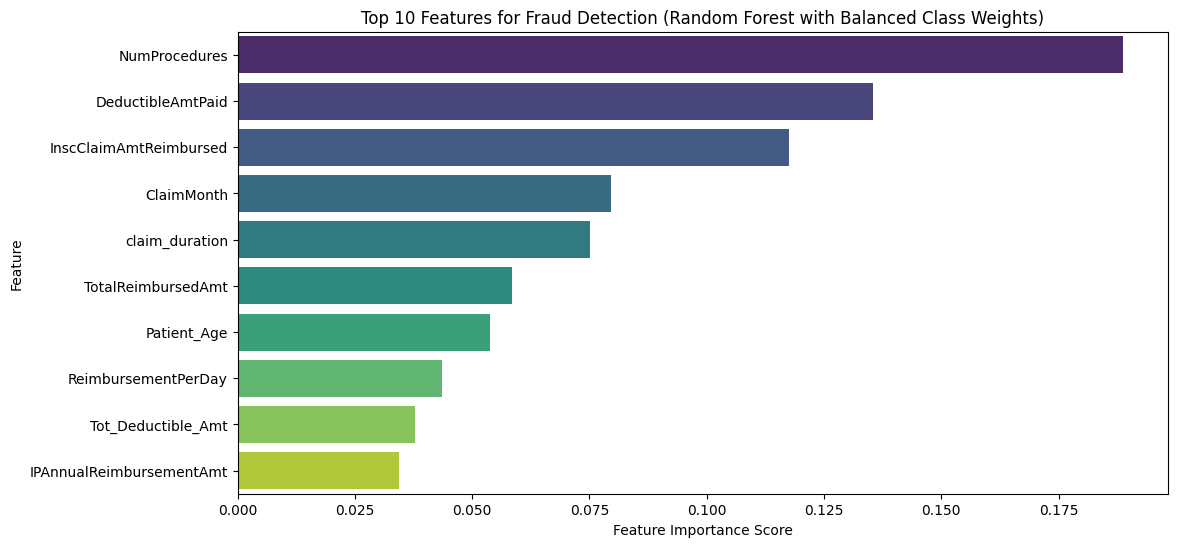

In [170]:
# Define features and target variable
X = df_selected.drop(columns=['PotentialFraud'])  
y = df_selected['PotentialFraud'].map({'Yes': 1, 'No': 0}) 

# Handle missing values
X.fillna(X.median(numeric_only=True), inplace=True)

# Standardize the features (optional for tree-based models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train the Random Forest model with class_weight='balanced'
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Extract feature importance from Random Forest
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# Sort features by importance in descending order
feature_importance_df = feature_importances.sort_values(ascending=False).reset_index()
feature_importance_df.columns = ['Feature', 'Importance']

# Display the top 10 important features
top_10_features = feature_importance_df.head(10)
print("Top 10 Most Important Features:\n", top_10_features)

# Plot the top 10 features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
plt.title('Top 10 Features for Fraud Detection (Random Forest with Balanced Class Weights)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.show()

Accuracy: 0.9104
Precision: 0.5192
Recall: 0.5347
F1-score: 0.5268
ROC-AUC: 0.9101
Confusion Matrix:
 [[931  50]
 [ 47  54]]


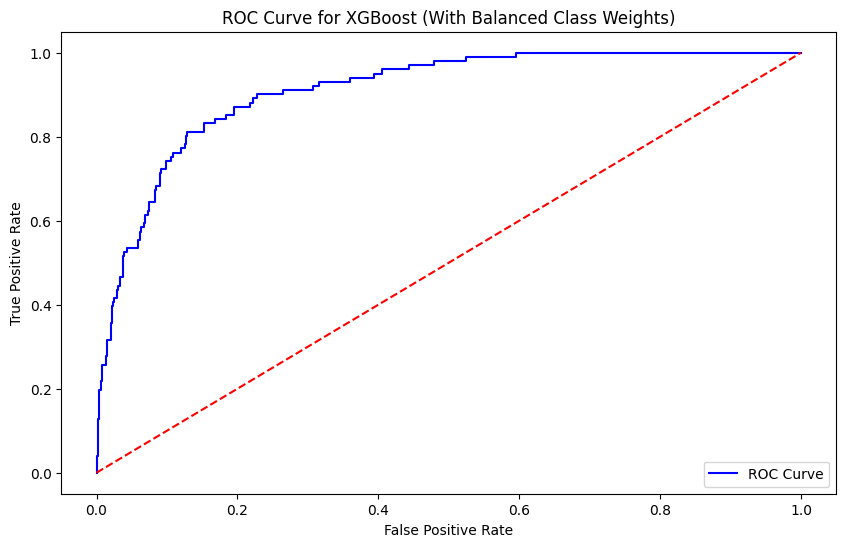

In [171]:
# 4B. XG Boost model
#XGBoost does not have class_weight like other models (e.g., RandomForestClassifier, LogisticRegression). 
#Instead, scale_pos_weight adjusts the weight for the minority class.
# Ensure an explicit copy to avoid SettingWithCopyWarning
df_selected = df_selected.copy()

# Replace infinite values with NaN
df_selected.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns with all NaN values
df_selected.dropna(axis=1, how='all', inplace=True)

# Define features and target variable
X = df_selected.drop(columns=['PotentialFraud'])  
y = df_selected['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert to binary labels

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Compute class weight ratio for imbalance handling in XGBoost
fraud_weight = (y == 0).sum() / (y == 1).sum()  # ratio of negative to positive samples

# Create and train XGBoost model with scale_pos_weight
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', XGBClassifier(random_state=42, scale_pos_weight=fraud_weight))])

model.fit(X_train, y_train)

# Make Predictions and Evaluate the Model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')

# Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost (With Balanced Class Weights)')
plt.legend(loc='lower right')
plt.show()



Top 10 Most Important Features:
                      Feature  Importance
0              NumProcedures    0.441077
1                 ClaimMonth    0.152977
2                Patient_Age    0.034040
3   OPAnnualReimbursementAmt    0.028850
4     InscClaimAmtReimbursed    0.026713
5      ChronicCond_Alzheimer    0.025257
6          DeductibleAmtPaid    0.024265
7  ChronicCond_KidneyDisease    0.023704
8         ChronicCond_Cancer    0.023506
9   IPAnnualReimbursementAmt    0.022453


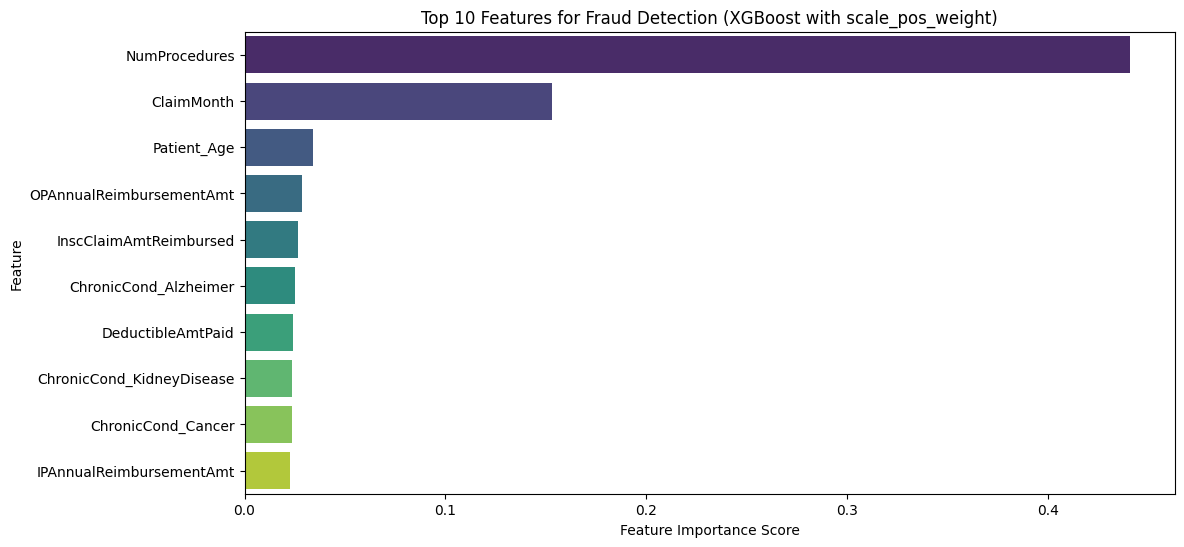

In [172]:
# Define features and target variable
X = df_selected.drop(columns=['PotentialFraud'])  
y = df_selected['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert to binary labels

# Handle missing values
X.fillna(X.median(numeric_only=True), inplace=True)

# Standardize the features (optional for XGBoost, but included for consistency)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Calculate the scale_pos_weight based on the class imbalance ratio
class_imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()  # ratio of negative to positive samples

# Train the XGBoost model with scale_pos_weight
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, 
                               random_state=42, scale_pos_weight=class_imbalance_ratio)

xgb_model.fit(X_train, y_train)

# Extract feature importance from XGBoost
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)

# Sort features by importance in descending order
feature_importance_df = feature_importances.sort_values(ascending=False).reset_index()
feature_importance_df.columns = ['Feature', 'Importance']

# Display the top 10 important features
top_10_features = feature_importance_df.head(10)
print("Top 10 Most Important Features:\n", top_10_features)

# Plot the top 10 features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
plt.title('Top 10 Features for Fraud Detection (XGBoost with scale_pos_weight)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.show()

C:\Docs\New folder\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 405, number of negative: 3923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2367
[LightGBM] [Info] Number of data points in the train set: 4328, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Docs\New folder\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Docs\New folder\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Accuracy: 0.8956
Precision: 0.4583
Recall: 0.6535
F1-score: 0.5388
ROC-AUC: 0.9088
Confusion Matrix:
 [[903  78]
 [ 35  66]]


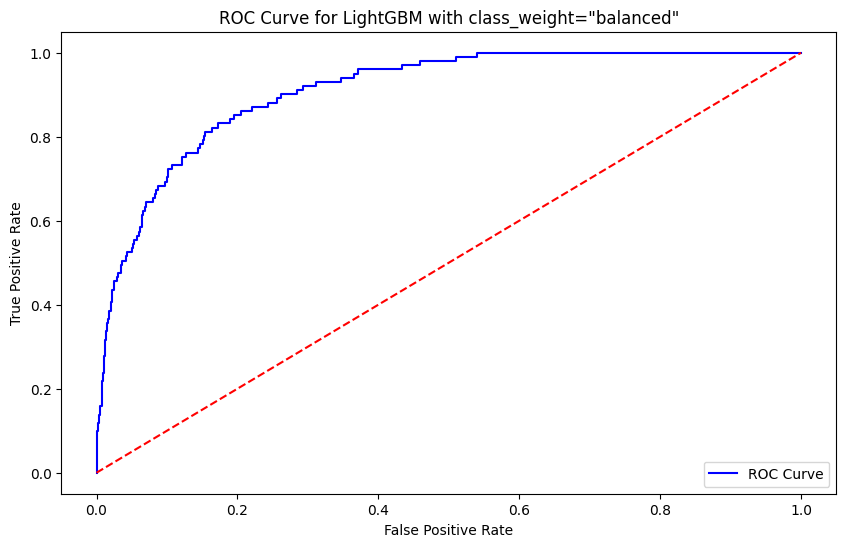

In [173]:
# 5. LightGBM model with class_weight='balanced'
# Ensure you're working with an explicit copy, not a slice
df_selected = df_selected.copy()

# Replace infinite values with NaN (this is safe now)
df_selected.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns with only NaN values
df_selected.dropna(axis=1, how='all', inplace=True)

# Define features and target variable
X = df_selected.drop(columns=['PotentialFraud'])
y = df_selected['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert to binary labels

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing numeric values with mean
    ('scaler', StandardScaler())  # Scale numeric data
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values with most frequent
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train LightGBM model pipeline with class_weight='balanced'
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LGBMClassifier(class_weight='balanced'))])  # Using LightGBM classifier

model.fit(X_train, y_train)

# Make Predictions and Evaluate the Model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC AUC

# Evaluate model performance with different classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')

# Step 10: Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM with class_weight="balanced"')
plt.legend(loc='lower right')
plt.show()

C:\Docs\New folder\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 405, number of negative: 3923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 4328, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

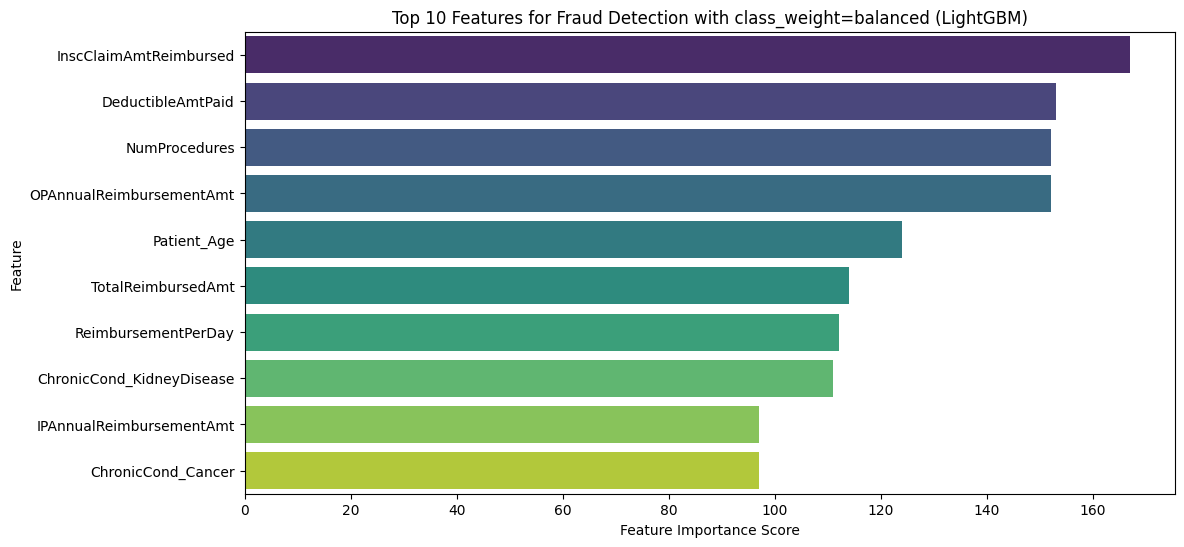

In [174]:
# Define features and target variable
X = df_selected.drop(columns=['PotentialFraud'])  
y = df_selected['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert to binary labels

# Handle missing values
X.fillna(X.median(numeric_only=True), inplace=True)

# Standardize the features (optional for LightGBM, it works without scaling too)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train the LightGBM model with class_weight='balanced'
lgb_model = lgb.LGBMClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight='balanced')
lgb_model.fit(X_train, y_train)

# Extract feature importance from LightGBM
feature_importances = pd.Series(lgb_model.feature_importances_, index=X.columns)

# Sort features by importance in descending order
feature_importance_df = feature_importances.sort_values(ascending=False).reset_index()
feature_importance_df.columns = ['Feature', 'Importance']

# Display the top 10 important features
top_10_features = feature_importance_df.head(10)
print("Top 10 Most Important Features:\n", top_10_features)

# Plot the top 10 features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
plt.title('Top 10 Features for Fraud Detection with class_weight=balanced (LightGBM)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.show()

Accuracy: 0.8900
Precision: 0.4423
Recall: 0.6832
F1-score: 0.5370
ROC-AUC: 0.9082
Confusion Matrix:
 [[894  87]
 [ 32  69]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94       981
           1       0.44      0.68      0.54       101

    accuracy                           0.89      1082
   macro avg       0.70      0.80      0.74      1082
weighted avg       0.92      0.89      0.90      1082



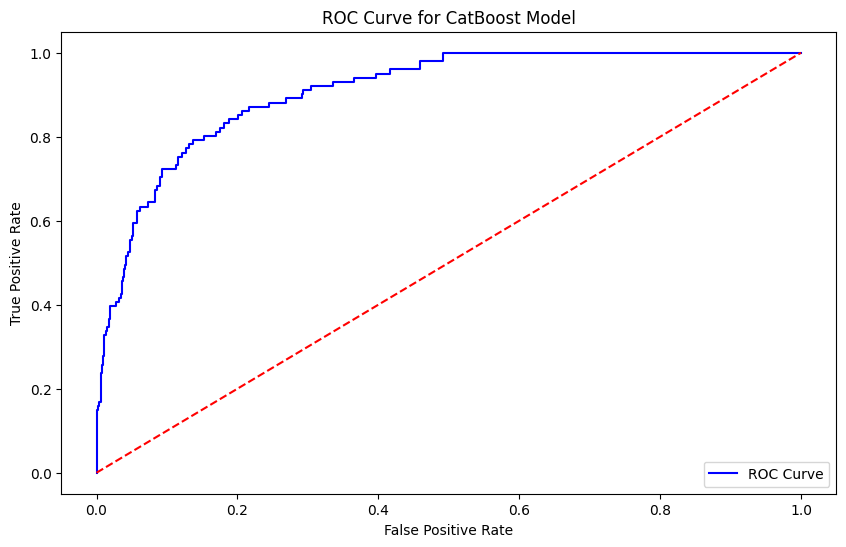

In [175]:
# 6B. CAT Boost model with class_weight=balanced
#CatBoost doesn't directly support a class_weight='balanced' argument, you need to compute the class weights manually and pass them to the classifier.
# Replace infinities with NaN
df_selected.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns with only NaN values
df_selected.dropna(axis=1, how='all', inplace=True)

# Define features and target variable
X = df_selected.drop(columns=['PotentialFraud'])  
y = df_selected['PotentialFraud'].map({'Yes': 1, 'No': 0})  # Convert target to numeric

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train CatBoost model pipeline with class weights
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', CatBoostClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, 
                                                          loss_function='Logloss', verbose=0, random_state=42,
                                                          class_weights=class_weight_dict))])

model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Confusion Matrix:\n {conf_matrix}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))

# Visualize the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CatBoost Model')
plt.legend(loc='lower right')
plt.show()

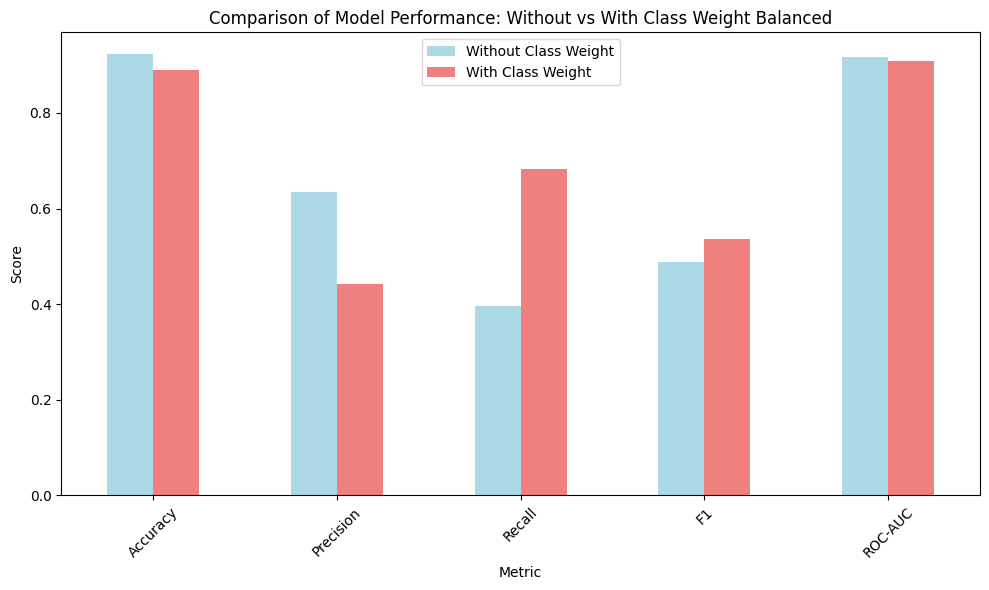

In [176]:
# Function to calculate performance metrics
def get_metrics(model, X_train, X_test, y_train, y_test):
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    return accuracy, precision, recall, f1, roc_auc

# Define models with and without class_weight='balanced'
model_no_class_weight = Pipeline(steps=[('preprocessor', preprocessor),
                                         ('classifier', CatBoostClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, 
                                                                           loss_function='Logloss', verbose=0, random_state=42))])

model_with_class_weight = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('classifier', CatBoostClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, 
                                                                           loss_function='Logloss', verbose=0, random_state=42,
                                                                           class_weights=class_weight_dict))])

# Train models
model_no_class_weight.fit(X_train, y_train)
model_with_class_weight.fit(X_train, y_train)

# Get performance metrics for both models
metrics_no_class_weight = get_metrics(model_no_class_weight, X_train, X_test, y_train, y_test)
metrics_with_class_weight = get_metrics(model_with_class_weight, X_train, X_test, y_train, y_test)

# Prepare data for comparison plot
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
metrics_comparison = pd.DataFrame({
    'Metric': metrics_names,
    'Without Class Weight': metrics_no_class_weight,
    'With Class Weight': metrics_with_class_weight
})

# Plot the comparison
metrics_comparison.set_index('Metric').plot(kind='bar', figsize=(10, 6), color=['lightblue', 'lightcoral'])
plt.title('Comparison of Model Performance: Without vs With Class Weight Balanced')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()